In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys

import numpy as np

sys.path.append("../..")

import matplotlib.pyplot as plt
import seaborn as sns

from xlstm_scaling_laws.analysis.fit_inference_time_model.objective_funcs import (
    InferenceModelObjectiveConfig,
    get_inference_time_model_objective_func,
)
from xlstm_scaling_laws.fitting.common.initialization import (
    generate_initialization_sweep,
)
from xlstm_scaling_laws.fitting.common.run_fit import (
    OptimizationConfig,
    run_optimization,
)
from xlstm_scaling_laws.load_data.inference_time import load_inference_time_data
from xlstm_scaling_laws.model_accounting.inference_time_model.mlstm_runtime_model import (
    predict_runtime_mlstm_ttft,
)

# xLSTM TTFT fit

This works for the simple linear_flops and linear_memops params.


In [2]:
ttft_df, step_time_df = load_inference_time_data("xlstm")

In [3]:
model = "xlstm_400m"
df = ttft_df.dropna()
df = df[df[("input_params", "prefill")] != 0][
    df[("model", "model_tag")] == model
]  # [df[("input_params", "batchsize")] == 8]
data_df = df.copy()

data_df

/tmp/ipykernel_198196/2612369068.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model]#[df[("input_params", "batchsize")] == 8]


model             input_params         measured_data  \
    model_type   model_tag    batchsize prefill    num_params   
131      xlstm  xlstm_400m            1     128     406856896   
132      xlstm  xlstm_400m            1     256     406856896   
133      xlstm  xlstm_400m            1     512     406856896   
134      xlstm  xlstm_400m            1    1024     406856896   
135      xlstm  xlstm_400m            1    2048     406856896   
136      xlstm  xlstm_400m            1    4096     406856896   
137      xlstm  xlstm_400m            1    8192     406856896   
138      xlstm  xlstm_400m            1   12288     406856896   
139      xlstm  xlstm_400m            1   16384     406856896   
141      xlstm  xlstm_400m            2     128     406856896   
142      xlstm  xlstm_400m            2     256     406856896   
143      xlstm  xlstm_400m            2     512     406856896   
144      xlstm  xlstm_400m            2    1024     406856896   
145      xlstm  xlstm_400m            2    2048     406856896   
146      xlstm  xlstm_400m            2    4096     406856896   
147      xlstm  xlstm_400m            2    8192     406856896   
148      xlstm  xlstm_400m            2   12288     406856896   
149      xlstm  xlstm_400m            2   16384     406856896   
151      xlstm  xlstm_400m            4     128     406856896   
152      xlstm  xlstm_400m            4     256     406856896   
153      xlstm  xlstm_400m            4     512     406856896   
154      xlstm  xlstm_400m            4    1024     406856896   
155      xlstm  xlstm_400m            4    2048     406856896   
156      xlstm  xlstm_400m            4    4096     406856896   
157      xlstm  xlstm_400m            4    8192     406856896   
158      xlstm  xlstm_400m            4   12288     406856896   
159      xlstm  xlstm_400m            4   16384     406856896   
161      xlstm  xlstm_400m            8     128     406856896   
162      xlstm  xlstm_400m            8     256     406856896   
163      xlstm  xlstm_400m            8     512     406856896   
164      xlstm  xlstm_400m            8    1024     406856896   
165      xlstm  xlstm_400m            8    2048     406856896   
166      xlstm  xlstm_400m            8    4096     406856896   
167      xlstm  xlstm_400m            8    8192     406856896   
171      xlstm  xlstm_400m           16     128     406856896   
172      xlstm  xlstm_400m           16     256     406856896   
173      xlstm  xlstm_400m           16     512     406856896   
174      xlstm  xlstm_400m           16    1024     406856896   
175      xlstm  xlstm_400m           16    2048     406856896   
176      xlstm  xlstm_400m           16    4096     406856896   
181      xlstm  xlstm_400m           32     128     406856896   
182      xlstm  xlstm_400m           32     256     406856896   
183      xlstm  xlstm_400m           32     512     406856896   
184      xlstm  xlstm_400m           32    1024     406856896   
185      xlstm  xlstm_400m           32    2048     406856896   
191      xlstm  xlstm_400m           64     128     406856896   
192      xlstm  xlstm_400m           64     256     406856896   
193      xlstm  xlstm_400m           64     512     406856896   
194      xlstm  xlstm_400m           64    1024     406856896   
201      xlstm  xlstm_400m          128     128     406856896   
202      xlstm  xlstm_400m          128     256     406856896   
203      xlstm  xlstm_400m          128     512     406856896   
211      xlstm  xlstm_400m          256     128     406856896   
212      xlstm  xlstm_400m          256     256     406856896   
221      xlstm  xlstm_400m          384     128     406856896   
231      xlstm  xlstm_400m          512     128     406856896   
241      xlstm  xlstm_400m          768     128     406856896   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
131           1170392064       

In [4]:
optim_cfg = OptimizationConfig(
    objective_func_config=InferenceModelObjectiveConfig(
        huber_delta=100,
        filter_zero_prefill=True,
        fit_data="ttft",
        fit_model="xlstm",
        runtime_model_mode="log_linear_flops",  # "log_linear_flops" and adapting the initial condition does not work. "linear_sum_flops_memops", #"linear_flops",
        factor_causal=0.75,
        bytes_act=2,
        bytes_Cmn=4,
        bytes_w=2,
        override_df=data_df,
        reduce_loss="none",
        squeeze_loos=True,  # Squeeze the loss to avoid issues with broadcasting
    ),
    scipy_optim_module="least_squares",
    method="lm",
    bootstrap_seed=0,
    num_bootstrap_samples=-1,
    # initialization_grid={
    #     "alpha": [900e12],
    #     "beta": [3.35e13],
    #     "rho": [1e-14],
    # },
    initialization_grid={
        "alpha": [0.3 * 900e12],
        # "beta": [1.5 * 3.35e13],
        "eps": [2e-3],
        "eps_bp": [1e-6],
        # "beta": [np.log(1.5 * 3.35e13)],
        # "rho": [np.log(1e-14)],
    },
    tol=1e-15,
    other_optimization_kwargs=dict(
        xtol=1e-15,
        gtol=1e-15,
        # ftol=1e-14,
    ),
)
print(optim_cfg.initialization_grid)

{'alpha': [270000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


In [5]:
optim_res_df = run_optimization(
    config=optim_cfg,
    objective_func_generator=get_inference_time_model_objective_func,
)

Running optimization: 100%|██████████| 1/1 [00:11<00:00, 11.39s/it]


In [6]:
optim_res_df.T

0
idxes         init_idx                                                       0
              bootstrap_idx                                                  0
optim_params  alpha                                       240193184077444.4375
              eps                                                     0.002253
              eps_bp                                                  0.000001
optim_results loss           [2.012759262263097e-06, 0.00104255236304795, 0...
              message               `xtol` termination condition is satisfied.
              success                                                     True
              jac            [[-8.244691295908627e-18, 0.011561518748067802...
              nfev                                                         109
              njev                                                        None
              status                                                         3
init_params   alpha                                          270000000000000.0
              eps                                                        0.002
              eps_bp                                                  0.000001

In [7]:
opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
# if optim_cfg.objective_func_config.runtime_model_mode.startswith("log_"):
#     opt_params = {k: float(np.exp(v)) for k, v in opt_params.items()}
print(opt_params)

{'alpha': 240193184077444.44, 'eps': 0.0022532372396382276, 'eps_bp': 1e-06}


In [8]:
# opt_params = {
#     "alpha": 0.4 * 900e12,
# }
# opt_params

In [9]:
# careful if you get a typerror here it is because we converted batch size to string in the next cell u
# and you rerun this cell
# so the batch size is not a number anymore
# pred_ttft_df = predict_runtime_mlstm_ttft(
#     ttft_df=df.iloc[:, :],
#     **{'alpha': 900e12, 'beta': 3.35e13, 'rho': 1e-14},
#     mode="attainable_flops_min", #"attainable_flops_logsumexp",
# )
# manual check
# opt_params["alpha"] = 2.38e+14
# opt_params["eps"] = 2.2e-3

pred_ttft_df = predict_runtime_mlstm_ttft(
    ttft_df=data_df.iloc[:, :],
    **opt_params,
    mode="linear_flops",
)

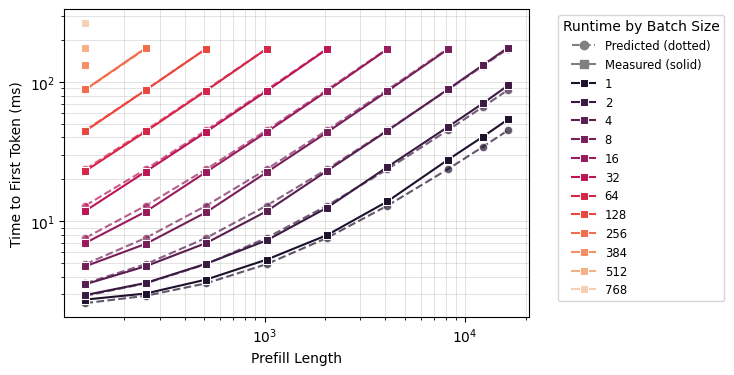

In [10]:
df = pred_ttft_df.copy()
# bs = 8
# df = df[df[("input_params", "batchsize")] == bs]

df = df[df[("model", "model_tag")] == model][df[("input_params", "batchsize")] < 2000]
df[("input_params", "batchsize")] = df[("input_params", "batchsize")].astype(str)
df[("pred", "runtime")] = df[("pred", "runtime")]
# ax = sns.lineplot(df, x=("input_params", "prefill"), y=('predicted_data', 'pred'), hue=("model", "model_tag"), markers=True, dashes=False)
plt.figure(figsize=(6, 4))
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("pred", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="o",
    linestyle="--",
    alpha=0.7,
    palette="rocket",
    legend=False,
)
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("measured_data", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="s",
    legend="auto",
    palette="rocket",
)
ax.set_ylabel("Time to First Token (ms)")
ax.set_xlabel("Prefill Length")
# # ax = sns.lineplot(df, x=("input_params", "prefill"), y=('measured_data', 'runtime'), hue=('measured_data', 'num_params'), markers=True, dashes=False)
# Custom legend handles
import matplotlib.lines as mlines

dotted_line = mlines.Line2D(
    [], [], color="gray", linestyle="--", marker="o", label="Predicted (dotted)"
)
solid_line = mlines.Line2D(
    [], [], color="gray", linestyle="-", marker="s", label="Measured (solid)"
)
# header

# Existing legend handles (for batchsize)
handles, labels = ax.get_legend_handles_labels()

# Combine custom and existing handles
custom_handles = [dotted_line, solid_line]
ax.legend(
    custom_handles + handles,
    ["Predicted (dotted)", "Measured (solid)"] + labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Runtime by Batch Size",
    fontsize="small",
)

# param_str = ", ".join([f"{k}={v:.2e}" for k, v in opt_params.items()])
# ax.set_title(f"TTFT Runtime Prediction for {model}: {param_str}")
ax.grid(True, which="both", ls="-", lw=0.5, alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(
    os.path.join("plots", f"ttft_runtime_prediction_xlstm.pdf"),
    bbox_inches="tight",
    dpi=300,
)

In [11]:
pred_ttft_df[["input_params", "pred"]]

input_params                pred                                     \
       batchsize prefill     runtime arithmetic_intensity    flops_algo   
131            1     128    2.588154            88.403063  8.044475e+10   
132            1     256    2.922642           144.962643  1.607865e+11   
133            1     512    3.591618           213.244206  3.214699e+11   
134            1    1024    4.929570           278.979460  6.428368e+11   
135            1    2048    7.605473           329.828627  1.285571e+12   
136            1    4096   12.957281           362.905746  2.571038e+12   
137            1    8192   23.660895           382.064726  5.141974e+12   
138            1   12288   34.364510           388.908831  7.712909e+12   
139            1   16384   45.068125           392.423702  1.028384e+13   
141            2     128    2.923071           145.041835  1.608895e+11   
142            2     256    3.592047           213.297731  3.215730e+11   
143            2     512    4.929999           279.011491  6.429399e+11   
144            2    1024    7.605902           329.846198  1.285674e+12   
145            2    2048   12.957710           362.914924  2.571141e+12   
146            2    4096   23.661324           382.069408  5.142077e+12   
147            2    8192   45.068554           392.426065  1.028395e+13   
148            2   12288   66.475783           396.004289  1.542582e+13   
149            2   16384   87.883012           397.818002  2.056769e+13   
151            4     128    3.592905           213.404758  3.217790e+11   
152            4     256    4.930857           279.075546  6.431459e+11   
153            4     512    7.606760           329.881338  1.285880e+12   
154            4    1024   12.958568           362.933280  2.571347e+12   
155            4    2048   23.662182           382.078773  5.142283e+12   
156            4    4096   45.069412           392.430792  1.028415e+13   
157            4    8192   87.883870           397.820376  2.056789e+13   
158            4   12288  130.698329           399.650002  3.085164e+13   
159            4   16384  173.512787           400.571150  4.113538e+13   
161            8     128    4.932572           279.203621  6.435580e+11   
162            8     256    7.608476           329.951605  1.286292e+12   
163            8     512   12.960283           362.969988  2.571759e+12   
164            8    1024   23.663898           382.097501  5.142695e+12   
165            8    2048   45.071127           392.440245  1.028457e+13   
166            8    4096   87.885586           397.825124  2.056831e+13   
167            8    8192  173.514503           400.573529  4.113579e+13   
171           16     128    7.611907           330.092093  1.287116e+12   
172           16     256   12.963715           363.043391  2.572584e+12   
173           16     512   23.667329           382.134955  5.143519e+12   
174           16    1024   45.074559           392.459150  1.028539e+13   
175           16    2048   87.889017           397.834619  2.056913e+13   
176           16    4096  173.517934           400.578287  4.113661e+13   
181           32     128   12.970577           363.190145  2.574232e+12   
182           32     256   23.674192           382.209848  5.145167e+12   
183           32     512   45.081421           392.496957  1.028704e+13   
184           32    1024   87.895880           397.853610  2.057078e+13   
185           32    2048  173.524797           400.587804  4.113826e+13   
191           64     128   23.687917           382.359579  5.148464e+12   
192           64     256   45.095146           392.572556  1.029033e+13   
193           64     512   87.909605           397.891587  2.057408e+13   
194           64    1024  173.538522           400.606836  4.114156e+13   
201          128     128   45.122597           392.723697  1.029693e+13   
202          128     256   87.937056           397.967526  2.058067e+13   
203          128     512  173

In [12]:
data_df

model             input_params         measured_data  \
    model_type   model_tag    batchsize prefill    num_params   
131      xlstm  xlstm_400m            1     128     406856896   
132      xlstm  xlstm_400m            1     256     406856896   
133      xlstm  xlstm_400m            1     512     406856896   
134      xlstm  xlstm_400m            1    1024     406856896   
135      xlstm  xlstm_400m            1    2048     406856896   
136      xlstm  xlstm_400m            1    4096     406856896   
137      xlstm  xlstm_400m            1    8192     406856896   
138      xlstm  xlstm_400m            1   12288     406856896   
139      xlstm  xlstm_400m            1   16384     406856896   
141      xlstm  xlstm_400m            2     128     406856896   
142      xlstm  xlstm_400m            2     256     406856896   
143      xlstm  xlstm_400m            2     512     406856896   
144      xlstm  xlstm_400m            2    1024     406856896   
145      xlstm  xlstm_400m            2    2048     406856896   
146      xlstm  xlstm_400m            2    4096     406856896   
147      xlstm  xlstm_400m            2    8192     406856896   
148      xlstm  xlstm_400m            2   12288     406856896   
149      xlstm  xlstm_400m            2   16384     406856896   
151      xlstm  xlstm_400m            4     128     406856896   
152      xlstm  xlstm_400m            4     256     406856896   
153      xlstm  xlstm_400m            4     512     406856896   
154      xlstm  xlstm_400m            4    1024     406856896   
155      xlstm  xlstm_400m            4    2048     406856896   
156      xlstm  xlstm_400m            4    4096     406856896   
157      xlstm  xlstm_400m            4    8192     406856896   
158      xlstm  xlstm_400m            4   12288     406856896   
159      xlstm  xlstm_400m            4   16384     406856896   
161      xlstm  xlstm_400m            8     128     406856896   
162      xlstm  xlstm_400m            8     256     406856896   
163      xlstm  xlstm_400m            8     512     406856896   
164      xlstm  xlstm_400m            8    1024     406856896   
165      xlstm  xlstm_400m            8    2048     406856896   
166      xlstm  xlstm_400m            8    4096     406856896   
167      xlstm  xlstm_400m            8    8192     406856896   
171      xlstm  xlstm_400m           16     128     406856896   
172      xlstm  xlstm_400m           16     256     406856896   
173      xlstm  xlstm_400m           16     512     406856896   
174      xlstm  xlstm_400m           16    1024     406856896   
175      xlstm  xlstm_400m           16    2048     406856896   
176      xlstm  xlstm_400m           16    4096     406856896   
181      xlstm  xlstm_400m           32     128     406856896   
182      xlstm  xlstm_400m           32     256     406856896   
183      xlstm  xlstm_400m           32     512     406856896   
184      xlstm  xlstm_400m           32    1024     406856896   
185      xlstm  xlstm_400m           32    2048     406856896   
191      xlstm  xlstm_400m           64     128     406856896   
192      xlstm  xlstm_400m           64     256     406856896   
193      xlstm  xlstm_400m           64     512     406856896   
194      xlstm  xlstm_400m           64    1024     406856896   
201      xlstm  xlstm_400m          128     128     406856896   
202      xlstm  xlstm_400m          128     256     406856896   
203      xlstm  xlstm_400m          128     512     406856896   
211      xlstm  xlstm_400m          256     128     406856896   
212      xlstm  xlstm_400m          256     256     406856896   
221      xlstm  xlstm_400m          384     128     406856896   
231      xlstm  xlstm_400m          512     128     406856896   
241      xlstm  xlstm_400m          768     128     406856896   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
131           1170392064       

In [13]:
# plot prediction for very long prefill
import pandas as pd

df = data_df.copy()
pdf = df[["model", "input_params", "model_params"]][
    df[("input_params", "batchsize")] == 8
]
ss = pdf.iloc[0, :]

In [14]:
prefills = [
    2000,
    4000,
    8000,
    16000,
    32e3,
    64e3,
    128e3,
]  # 256e3, 500e3, 1e6, 2e6, 4e6, 8e6, 16e6, 32e6, 64e6, 128e6

sss = [ss.copy() for _ in range(len(prefills))]
for i, p in enumerate(prefills):
    sss[i][("input_params", "prefill")] = p
pdf2 = pd.DataFrame(sss)
pdf

model             input_params         model_params                \
    model_type   model_tag    batchsize prefill    num_heads embedding_dim   
161      xlstm  xlstm_400m            8     128          4.0        1024.0   
162      xlstm  xlstm_400m            8     256          4.0        1024.0   
163      xlstm  xlstm_400m            8     512          4.0        1024.0   
164      xlstm  xlstm_400m            8    1024          4.0        1024.0   
165      xlstm  xlstm_400m            8    2048          4.0        1024.0   
166      xlstm  xlstm_400m            8    4096          4.0        1024.0   
167      xlstm  xlstm_400m            8    8192          4.0        1024.0   

                                                                          \
    num_blocks qk_dim_factor ffn_proj_factor ffn_round_up_to_multiple_of   
161       24.0           0.5          2.6667                        64.0   
162       24.0           0.5          2.6667                        64.0   
163       24.0           0.5          2.6667                        64.0   
164       24.0           0.5          2.6667                        64.0   
165       24.0           0.5          2.6667                        64.0   
166       24.0           0.5          2.6667                        64.0   
167       24.0           0.5          2.6667                        64.0   

                                   
    vocab_size chunk_size ffn_dim  
161    50304.0      128.0  2752.0  
162    50304.0      128.0  2752.0  
163    50304.0      128.0  2752.0  
164    50304.0      128.0  2752.0  
165    50304.0      128.0  2752.0  
166    50304.0      128.0  2752.0  
167    50304.0      128.0  2752.0

In [15]:
pred_ttft_df2 = predict_runtime_mlstm_ttft(
    ttft_df=pdf2.iloc[:, :],
    **opt_params,
    mode="linear_flops",
)

Text(0.5, 1.0, 'TTFT Runtime Prediction for xlstm_400m')

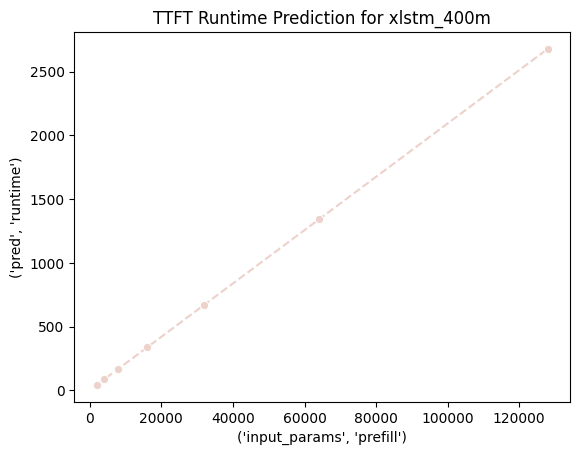

In [17]:
ax = sns.lineplot(
    pred_ttft_df2,
    x=("input_params", "prefill"),
    y=("pred", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="o",
    linestyle="--",
    alpha=1.0,
    legend=False,
)
ax.set_title(f"TTFT Runtime Prediction for {model}")
# ax.set_yscale("log")
# ax.set_xscale("log")

# Create multiple plots

This works for the simple linear_flops and linear_memops params.


In [18]:
ttft_df, step_time_df = load_inference_time_data("xlstm")

/tmp/ipykernel_198196/4108311982.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': [810000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


Running optimization: 100%|██████████| 1/1 [00:11<00:00, 11.35s/it]
/tmp/ipykernel_198196/4108311982.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 162911503707128.78, 'eps': 0.0012492365215286566, 'eps_bp': 1e-06}
{'alpha': [810000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


Running optimization: 100%|██████████| 1/1 [00:08<00:00,  8.04s/it]
/tmp/ipykernel_198196/4108311982.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 237044480071988.56, 'eps': 0.0019101130879424669, 'eps_bp': 1e-06}
{'alpha': [810000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


Running optimization: 100%|██████████| 1/1 [00:09<00:00,  9.47s/it]
/tmp/ipykernel_198196/4108311982.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 295067392762598.2, 'eps': 0.0018503444725705292, 'eps_bp': 1e-06}
{'alpha': [810000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


Running optimization: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]
/tmp/ipykernel_198196/4108311982.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 334839229925805.25, 'eps': 0.0015318797143846874, 'eps_bp': 1e-06}
{'alpha': [810000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


Running optimization: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]
/tmp/ipykernel_198196/4108311982.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 366392752093772.06, 'eps': 0.0022478636271753565, 'eps_bp': 1e-06}
{'alpha': [810000000000000.0], 'eps': [0.002], 'eps_bp': [1e-06]}


Running optimization: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it]

{'alpha': 405283925502210.4, 'eps': 0.003133575668553138, 'eps_bp': 1e-06}


Text(0, 0.5, 'Alpha [FLOPS/s]')

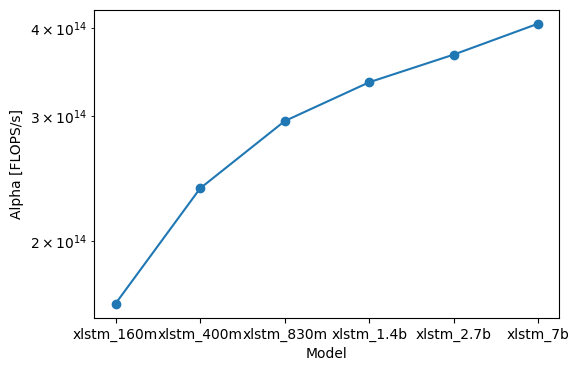

In [19]:
alphas = []
for model in [
    "xlstm_160m",
    "xlstm_400m",
    "xlstm_830m",
    "xlstm_1.4b",
    "xlstm_2.7b",
    "xlstm_7b",
]:
    df = ttft_df.dropna()
    df = df[df[("input_params", "prefill")] != 0][
        df[("model", "model_tag")] == model
    ]  # [df[("input_params", "batchsize")] == 8]
    data_df = df.copy()
    optim_cfg = OptimizationConfig(
        objective_func_config=InferenceModelObjectiveConfig(
            huber_delta=1,
            filter_zero_prefill=True,
            fit_data="ttft",
            fit_model="xlstm",
            runtime_model_mode="linear_flops",  # "linear_sum_flops_memops", #"linear_flops",
            factor_causal=0.75,
            bytes_act=2,
            bytes_Cmn=4,
            bytes_w=2,
            override_df=data_df,
            reduce_loss="none",
            squeeze_loos=True,  # Squeeze the loss to avoid issues with broadcasting
        ),
        scipy_optim_module="least_squares",
        method="lm",
        bootstrap_seed=0,
        num_bootstrap_samples=-1,
        # initialization_grid={
        #     "alpha": [900e12],
        #     "beta": [3.35e13],
        #     "rho": [1e-14],
        # },
        initialization_grid={
            # "alpha": [np.log(0.45 * 900e12)],
            "alpha": [0.9 * 900e12],
            # "beta": [1.5 * 3.35e13],
            "eps": [2e-3],
            "eps_bp": [1e-6],
            # "beta": [np.log(1.5 * 3.35e13)],
            # "rho": [np.log(1e-14)],
        },
        tol=1e-15,
        other_optimization_kwargs=dict(
            xtol=1e-15,
            gtol=1e-15,
            # ftol=1e-14,
        ),
    )
    print(optim_cfg.initialization_grid)

    optim_res_df = run_optimization(
        config=optim_cfg,
        objective_func_generator=get_inference_time_model_objective_func,
    )
    opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
    if optim_cfg.objective_func_config.runtime_model_mode.startswith("log_"):
        opt_params = {k: float(np.exp(v)) for k, v in opt_params.items()}
    print(opt_params)

    alphas.append((model, opt_params["alpha"]))

plt.figure(figsize=(6, 4))
plt.plot(*zip(*alphas), marker="o")
plt.yscale("log")
plt.xlabel("Model")
plt.ylabel("Alpha [FLOPS/s]")

In [20]:
for m, a in alphas:
    print(m, a)

xlstm_160m 162911503707128.78
xlstm_400m 237044480071988.56
xlstm_830m 295067392762598.2
xlstm_1.4b 334839229925805.25
xlstm_2.7b 366392752093772.06
xlstm_7b 405283925502210.4
